# Oracle-Reto 2: Análisis de sentimiento

*NUWE EVA*, la cadena de restauración fast food y healthy, sigue creciendo y queremos dar un paso más para mejorar y ofrecer el mejor servicio posible a nuestros clientes.

Queremos evolucionar y ofrecer nuevas capacidades a nuestro robot y talentoso camarero, *EVA*, añadiendo la función de poder detectar, a través de frases y palabras utilizadas por los comensales, el grado de satisfacción de los platos probados y así ver qué platos y productos han gustado más o menos a los clientes.

Nuestro robot ya sabe detectar lo que pedirán los comensales según los productos elegidos. Ahora queremos saber cuál es el feedback de cada cliente para detectar si le ha gustado o no el plato servido.

> Objetivo
Crea un modelo predictivo de **clasificación** para poder **ordenar y o catalogar las reseñas**. Primero entrena tu modelo con las reseñas de entrenamiento. Una vez tengas el modelo que maximice la puntuación F1 (macro.), utiliza las reseñas de prueba como entrada para tu modelo.

In [1]:
from numpy import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../Data/train.csv',index_col = [0])
test = pd.read_csv('../Data/test.csv',index_col = [0])

In [3]:
train.head()

,text,label,label_text
train_idx,,,
0,i really do recommend this to anyone in need o...,1,positive
1,very good every day camera fits nicely in the ...,1,positive
2,"but , dollar for dollar , this dvd player is p...",1,positive
3,i got this phone yesterday and didn ' t find a...,1,positive
4,1 ) price gb of storage,1,positive


In [4]:
test.head()

,text
test_idx,
0,fm receiver it has none
1,"the picture quality surprised me , when i firs..."
2,great video clip quality for a digital camera ...
3,creative did well on its rechargeable battery ...
4,i highly recommend this camera to anyone looki...


In [5]:
''' shape '''
print(f'shape de los datos train {train.shape}')
print(f'shape de los datos test {test.shape}')

shape de los datos train (3016, 3)
shape de los datos test (754, 1)


In [6]:
train.label.value_counts()

1    1926
0    1090
Name: label, dtype: int64

In [7]:
# import natural language tool kit
import nltk as nlp
import re

def tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte t0do el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

In [8]:
train['token'] = train['text'].apply(lambda x: tokenizar(x))
train[['text', 'token']].head()

,text,token
train_idx,,
0,i really do recommend this to anyone in need o...,"[really, do, recommend, this, to, anyone, in, ..."
1,very good every day camera fits nicely in the ...,"[very, good, every, day, camera, fits, nicely,..."
2,"but , dollar for dollar , this dvd player is p...","[but, dollar, for, dollar, this, dvd, player, ..."
3,i got this phone yesterday and didn ' t find a...,"[got, this, phone, yesterday, and, didn, find,..."
4,1 ) price gb of storage,"[price, gb, of, storage]"


In [9]:
Xtrain = train.explode('token')
Xtrain.drop(['label_text'], axis=1, inplace=True)
Xtrain.head()

,text,label,token
train_idx,,,
0,i really do recommend this to anyone in need o...,1,really
0,i really do recommend this to anyone in need o...,1,do
0,i really do recommend this to anyone in need o...,1,recommend
0,i really do recommend this to anyone in need o...,1,this
0,i really do recommend this to anyone in need o...,1,to


In [10]:
# Mean length and std of the reviews
Xtrain.groupby(['train_idx'])['token'].count().describe()

count    3016.000000
mean       16.096154
std         9.415842
min         1.000000
25%         9.000000
50%        14.000000
75%        21.000000
max        72.000000
Name: token, dtype: float64

In [11]:
# most used words in the reviews
Xtrain['token'].value_counts(ascending=False)

the          3212
and          1518
it           1335
to           1328
is           1193
             ... 
substance       1
earned          1
shelf           1
distorts        1
handful         1
Name: token, Length: 4554, dtype: int64

Podemos observar como las palabras más utilizadas en las *reviews* son en su mayoría pronombres o conjunciones, que no aportan información alguna.

Utilizaremos por tanto *stopwords* para eliminarlas.

In [12]:
from nltk.corpus import stopwords
# Obtain list of stopwords
stop_words = list(stopwords.words('english'))
print(f'ejemplos de stopwords: {stop_words[:10]}')

ejemplos de stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [13]:
# filtering stopwords
Xtrain = Xtrain[~(Xtrain["token"].isin(stop_words))]

In [14]:
# Lematize
lemma = nlp.WordNetLemmatizer()
Xtrain['token'] = [lemma.lemmatize(x) for x in Xtrain.token]

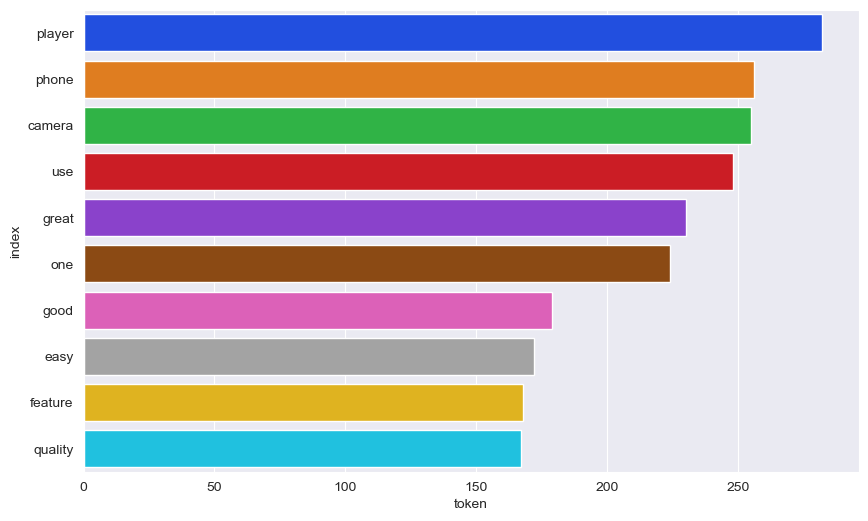

In [15]:
# Top 10 words without stopwords
plt.figure(figsize=(10, 6))
counts  = Xtrain['token'].value_counts(ascending=False).reset_index().head(10)
sns.barplot(data = counts, y = 'index', x = 'token', orient= 'h', palette= 'bright')
plt.show()

In [16]:
Xtrain

,text,label,token
train_idx,,,
0,i really do recommend this to anyone in need o...,1,really
0,i really do recommend this to anyone in need o...,1,recommend
0,i really do recommend this to anyone in need o...,1,anyone
0,i really do recommend this to anyone in need o...,1,need
0,i really do recommend this to anyone in need o...,1,new
...,...,...,...
3015,"the fm tuner , the 5g of storage , and the rem...",1,storage
3015,"the fm tuner , the 5g of storage , and the rem...",1,removable
3015,"the fm tuner , the 5g of storage , and the rem...",1,disk


In [18]:
Xtrain.to_csv('../Data/New/Xtrain.csv')